In [5]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, plotting, CoxPHFitter
from collections import Counter

# plt.style.use('ggplot')
plt.style.use('bmh')
# mpl.use("pgf")
mpl.rcParams.update({
    "grid.linestyle" : "dashed",
    "axes.facecolor" : "white",
    "axes.spines.top" : False,
    "axes.spines.right" : False,
    "legend.frameon" : False,
    "figure.figsize" : (8, 5),
    "figure.dpi" : 500,

    # saving settings for latex
    # https://timodenk.com/blog/exporting-matplotlib-plots-to-latex/
    # "pgf.texsystem": "pdflatex",
    # "font.family": "serif",
    # "text.usetex": True,
    # "pgf.rcfonts": False,
})

%matplotlib inline

In [6]:
# load the dataset and the extra data
df = pd.read_csv("./data/cad/data_cvd.csv", index_col=0, decimal='.')
df["Follow Up Data"] = pd.to_datetime(df["Follow Up Data"], format="%Y/%m/%d")
df["Data prelievo"] = pd.to_datetime(df["Data prelievo"], format="%Y/%m/%d")

df_7y = pd.read_csv("./data/cad/data_feat.csv", index_col=0, decimal='.')
df = df.merge(df_7y["Survive7Y"], how="left", left_index=True, right_index=True)

df["Death7Y"] = df["Survive7Y"].map(lambda x: (x+1)%2)
# df.info()

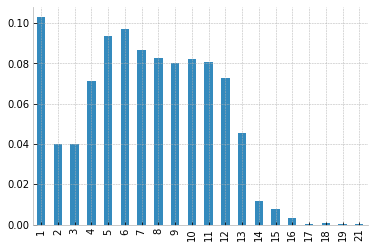

In [7]:
# birth event: "Data prelievo"
# death event: "Death7Y"
# right-censoring occur if the patient is still alive at "Follow Up Data"

# duration and observation features
df_surv = pd.DataFrame()
df_surv["Death7Y"] = df["Death7Y"]
df_surv["duration"] = (df["Follow Up Data"] - df["Data prelievo"]).map(lambda x: (x.days//365) + 1)
df_surv["observed"] = df["CVD Death"]
df_surv["ID"] = np.random.randint(0, 1e6, size=len(df_surv))

# plot duration
df_surv["duration"].value_counts(normalize=True).sort_index().plot(kind='bar')
df_feat = pd.read_csv("./data/cad/data_feat.csv", index_col=0, decimal='.')
df_surv = df_feat.merge(df_surv, how="left", left_index=True, right_index=True)
# df_surv.to_csv("data/cad/data_surv.csv")

### 1- Survival Analysis On All The CAD Patients 
The plot indicates the % of CVD patients that survived after n years. For example, the probability for surviving more than 7 years is ~92%.

<AxesSubplot:title={'center':'Survival Function of CVD Patients (7 Years)'}, xlabel='Years', ylabel='Survive7Y'>

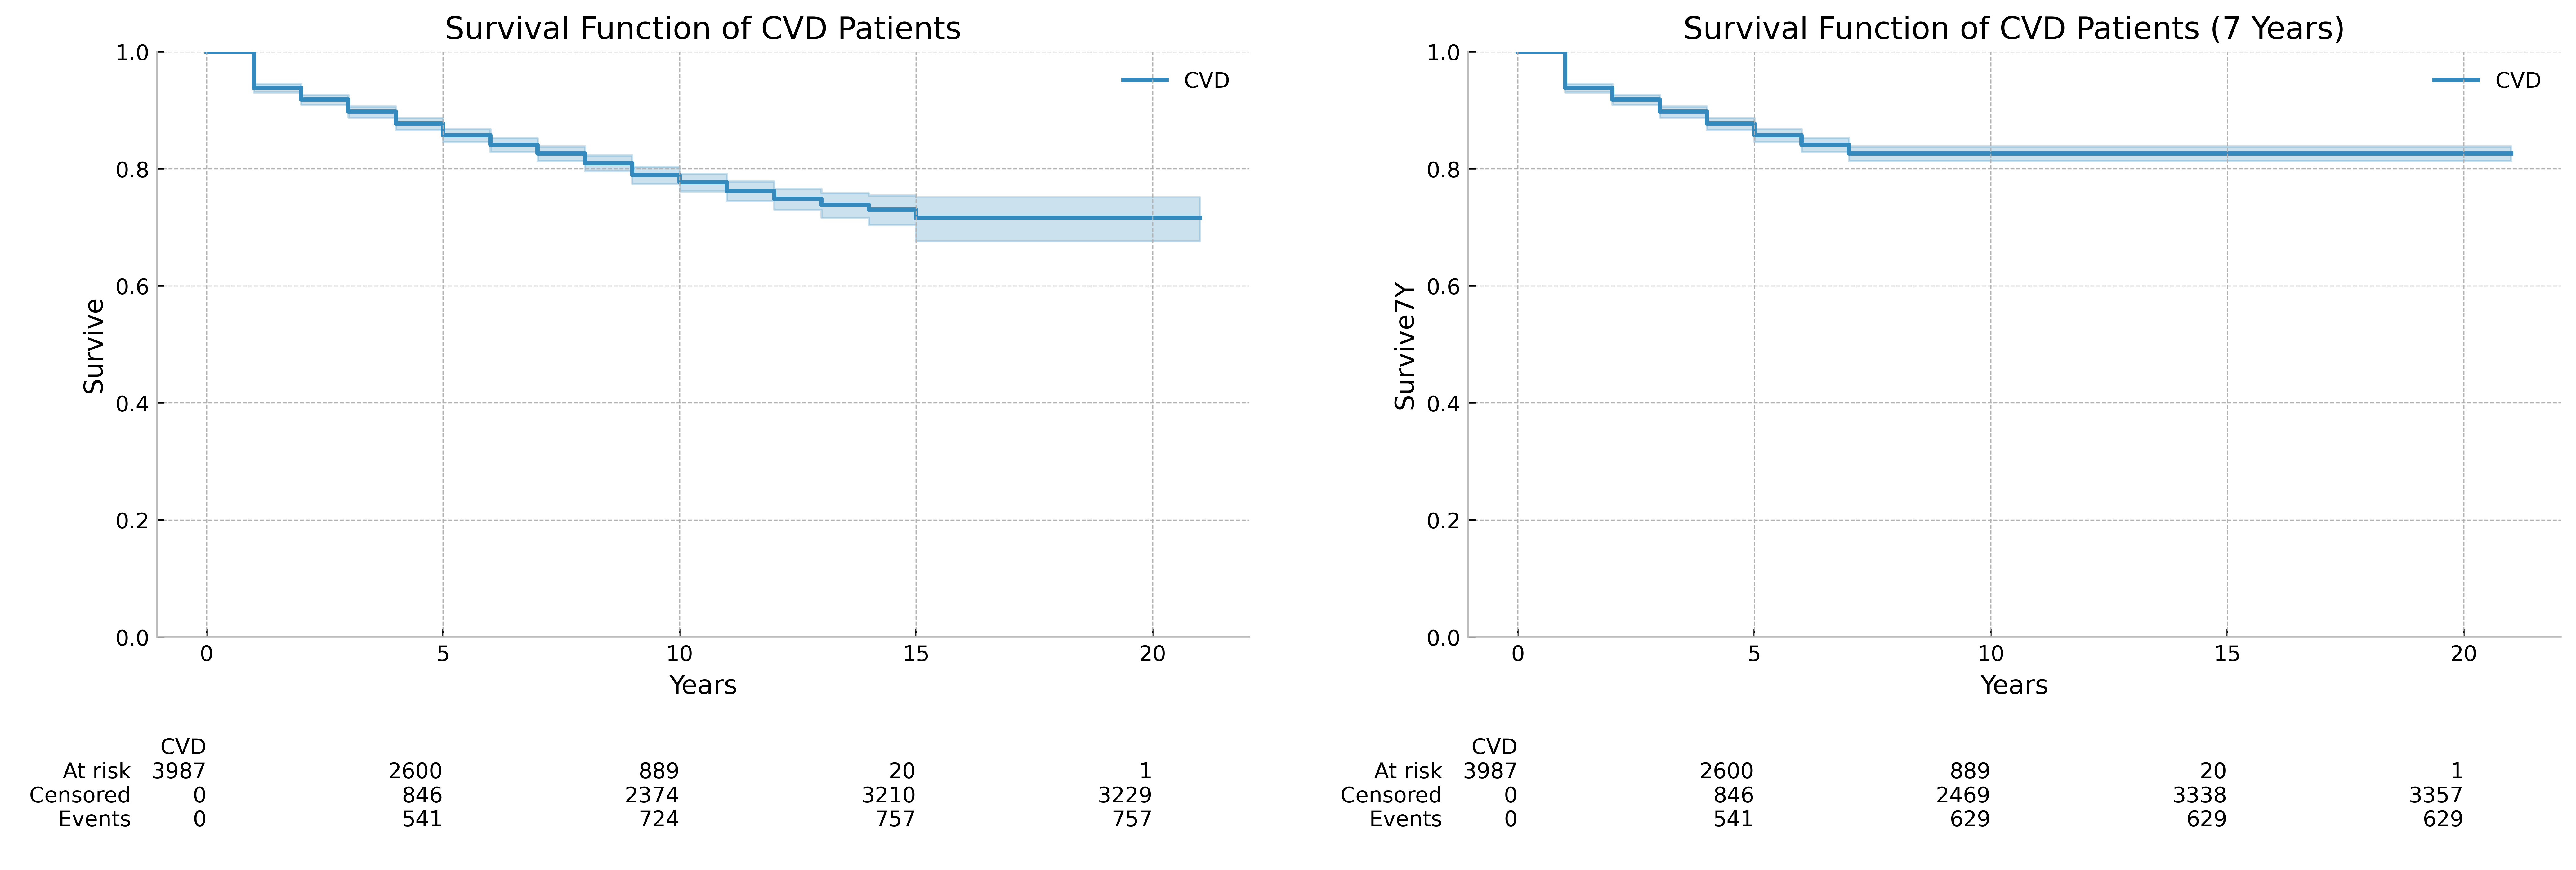

In [8]:
fig = plt.figure(figsize=(20, 5), dpi=500) 
fig_dims = (1, 2)
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot2grid(fig_dims, (0, 0))
kmf1 = KaplanMeierFitter()
kmf1.fit(df_surv["duration"], event_observed=df_surv["observed"], label="CVD")
kmf1.plot_survival_function()
plt.title('Survival Function of CVD Patients')
plt.xlabel("Years")
plt.ylabel("Survive")
plt.ylim(0, 1)
plotting.add_at_risk_counts(kmf1)

plt.subplot2grid(fig_dims, (0, 1))
kmf2 = KaplanMeierFitter()
kmf2.fit(df_surv["duration"], event_observed=df_surv["Death7Y"], label="CVD")
kmf2.plot_survival_function()
plt.title('Survival Function of CVD Patients (7 Years)')
plt.xlabel("Years")
plt.ylabel("Survive7Y")
plt.ylim(0, 1)
plotting.add_at_risk_counts(kmf2)

# plt.savefig("")
# kmf.median_survival_time_
# kmf.confidence_interval_

### 2- Survival Analysis univariate on the Test set

In [9]:
df_test = pd.read_csv("./data/cad/test.csv", index_col=0, decimal='.').sort_index()
df_test = df_test.merge(df_surv.loc[:, ["duration", "observed"]], how="left", left_index=True, right_index=True)
# df_test

68.63533834586467


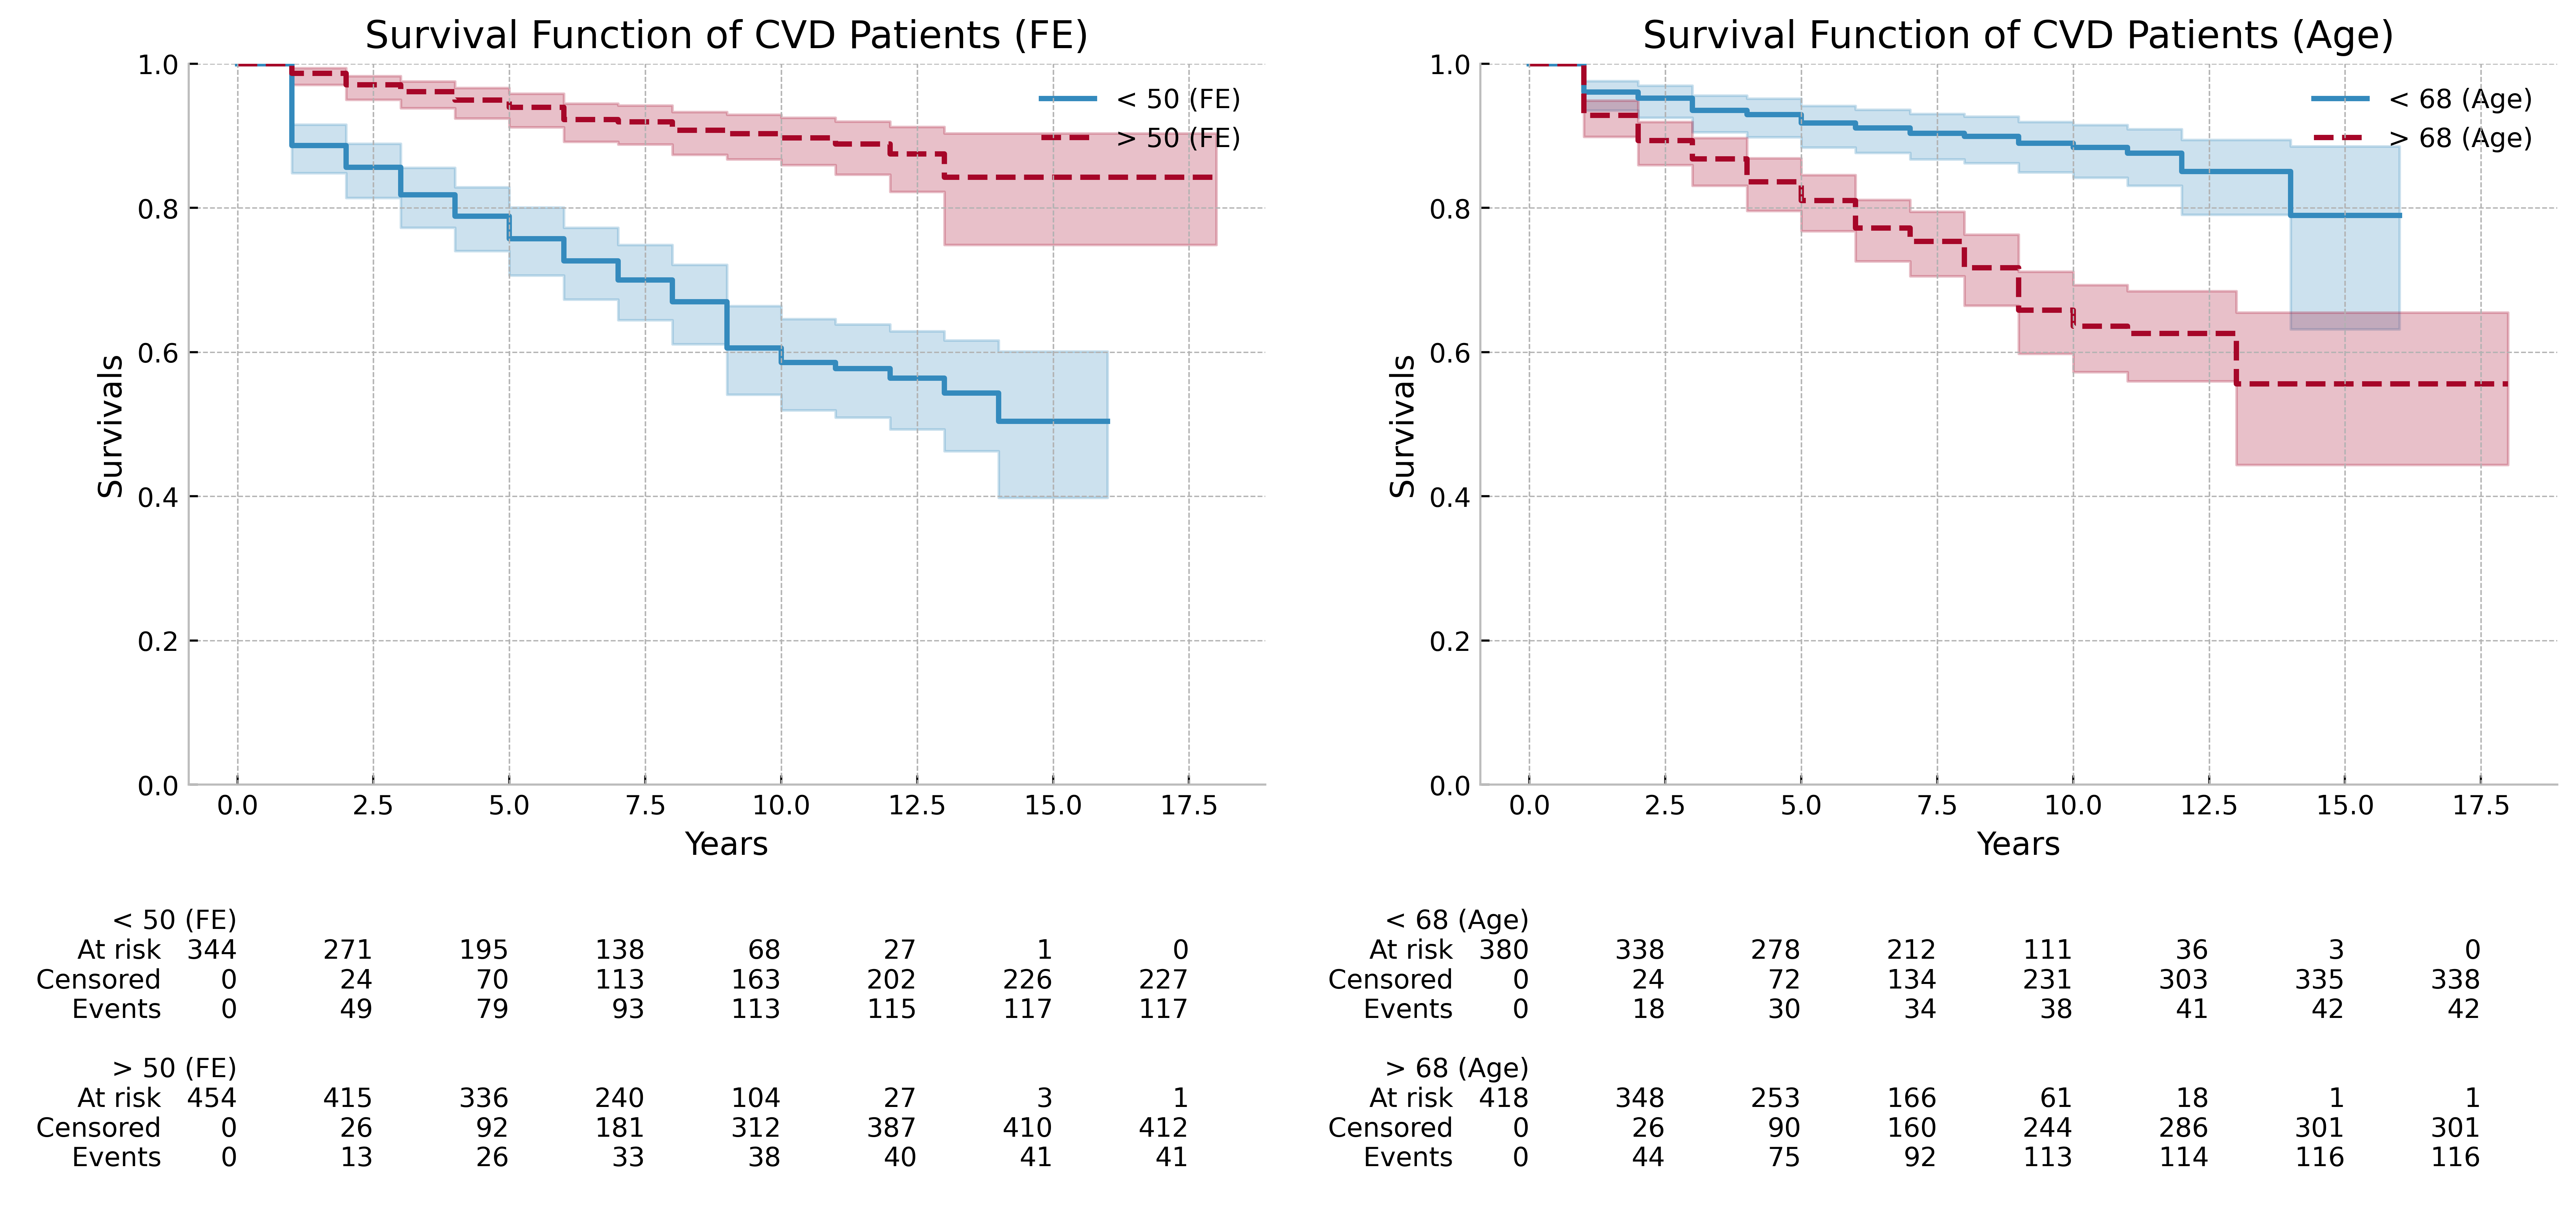

In [10]:
fig = plt.figure(figsize=(16, 5), dpi=500) 
fig_dims = (1, 2)
fig.subplots_adjust(hspace=0.2, wspace=0.2)

# Age
plt.subplot2grid(fig_dims, (0, 0))
mean = df_test["FE"].mean()
df_under_mean = df_test[df_test["FE"] < mean]
df_above_mean = df_test[df_test["FE"] > mean]

kmf1 = KaplanMeierFitter()
kmf1.fit(df_under_mean["duration"], event_observed=df_under_mean["observed"], label=f"< {int(mean)} (FE)")
kmf1.plot_survival_function()
kmf2 = KaplanMeierFitter()
kmf2.fit(df_above_mean["duration"], event_observed=df_above_mean["observed"], label=f"> {int(mean)} (FE)")
kmf2.plot_survival_function(linestyle="--")

plt.title('Survival Function of CVD Patients (FE)')
plt.xlabel("Years")
plt.ylabel("Survivals")
plt.ylim(0, 1)
plotting.add_at_risk_counts(kmf1, kmf2)

# FE
plt.subplot2grid(fig_dims, (0, 1))
mean = df_test["Age"].mean()
df_under_mean = df_test[df_test["Age"] < mean]
df_above_mean = df_test[df_test["Age"] > mean]

kmf1 = KaplanMeierFitter()
kmf1.fit(df_under_mean["duration"], event_observed=df_under_mean["observed"], label=f"< {int(mean)} (Age)")
kmf1.plot_survival_function()
kmf2 = KaplanMeierFitter()
kmf2.fit(df_above_mean["duration"], event_observed=df_above_mean["observed"], label=f"> {int(mean)} (Age)")
kmf2.plot_survival_function(linestyle="--")

plt.title('Survival Function of CVD Patients (Age)')
plt.xlabel("Years")
plt.ylabel("Survivals")
plt.ylim(0, 1)
plotting.add_at_risk_counts(kmf1, kmf2)
# plt.tight_layout()
print(mean)

### 2- Survival Analysis CAD Prediction Indicator (Test set)

In [49]:
def plot_kmf(df_pred, threshold):
    df_pred_under = df_pred[df_pred["ModelOutput"] <= threshold]
    df_pred_above = df_pred[df_pred["ModelOutput"] > threshold]

    kmf1 = KaplanMeierFitter()
    kmf1.fit(df_pred_under["duration"], event_observed=df_pred_under["observed"], label=f"<= {threshold}")
    kmf1.plot_survival_function()

    kmf2 = KaplanMeierFitter()
    kmf2.fit(df_pred_above["duration"], event_observed=df_pred_above["observed"], label=f"> {threshold}")
    kmf2.plot_survival_function(linestyle="--")

    plt.title('Survival Function of CAD Patients (Model Prediction Indicator)')
    plt.xlabel("Years")
    plt.ylabel("Survivals")
    plt.ylim(0, 1)
    plotting.add_at_risk_counts(kmf1, kmf2)

In [50]:
df_out = pd.read_csv("./data/cad/extra_test_output.csv", index_col=0, decimal='.')
df_out4 = pd.read_csv("./data/cad/extra_test_output4.csv", index_col=0, decimal='.')

# ModelOutput 27 features
df_test_pred = df_surv.drop(list(set(df_surv.index) - set(df_out.index)))
df_test_pred = df_test_pred.merge(df_out, how="left", left_index=True, right_index=True)

# ModelOutput 4 features
df_test4_pred = df_surv.drop(list(set(df_surv.index) - set(df_out4.index)))
df_test4_pred = df_test4_pred.merge(df_out4, how="left", left_index=True, right_index=True)

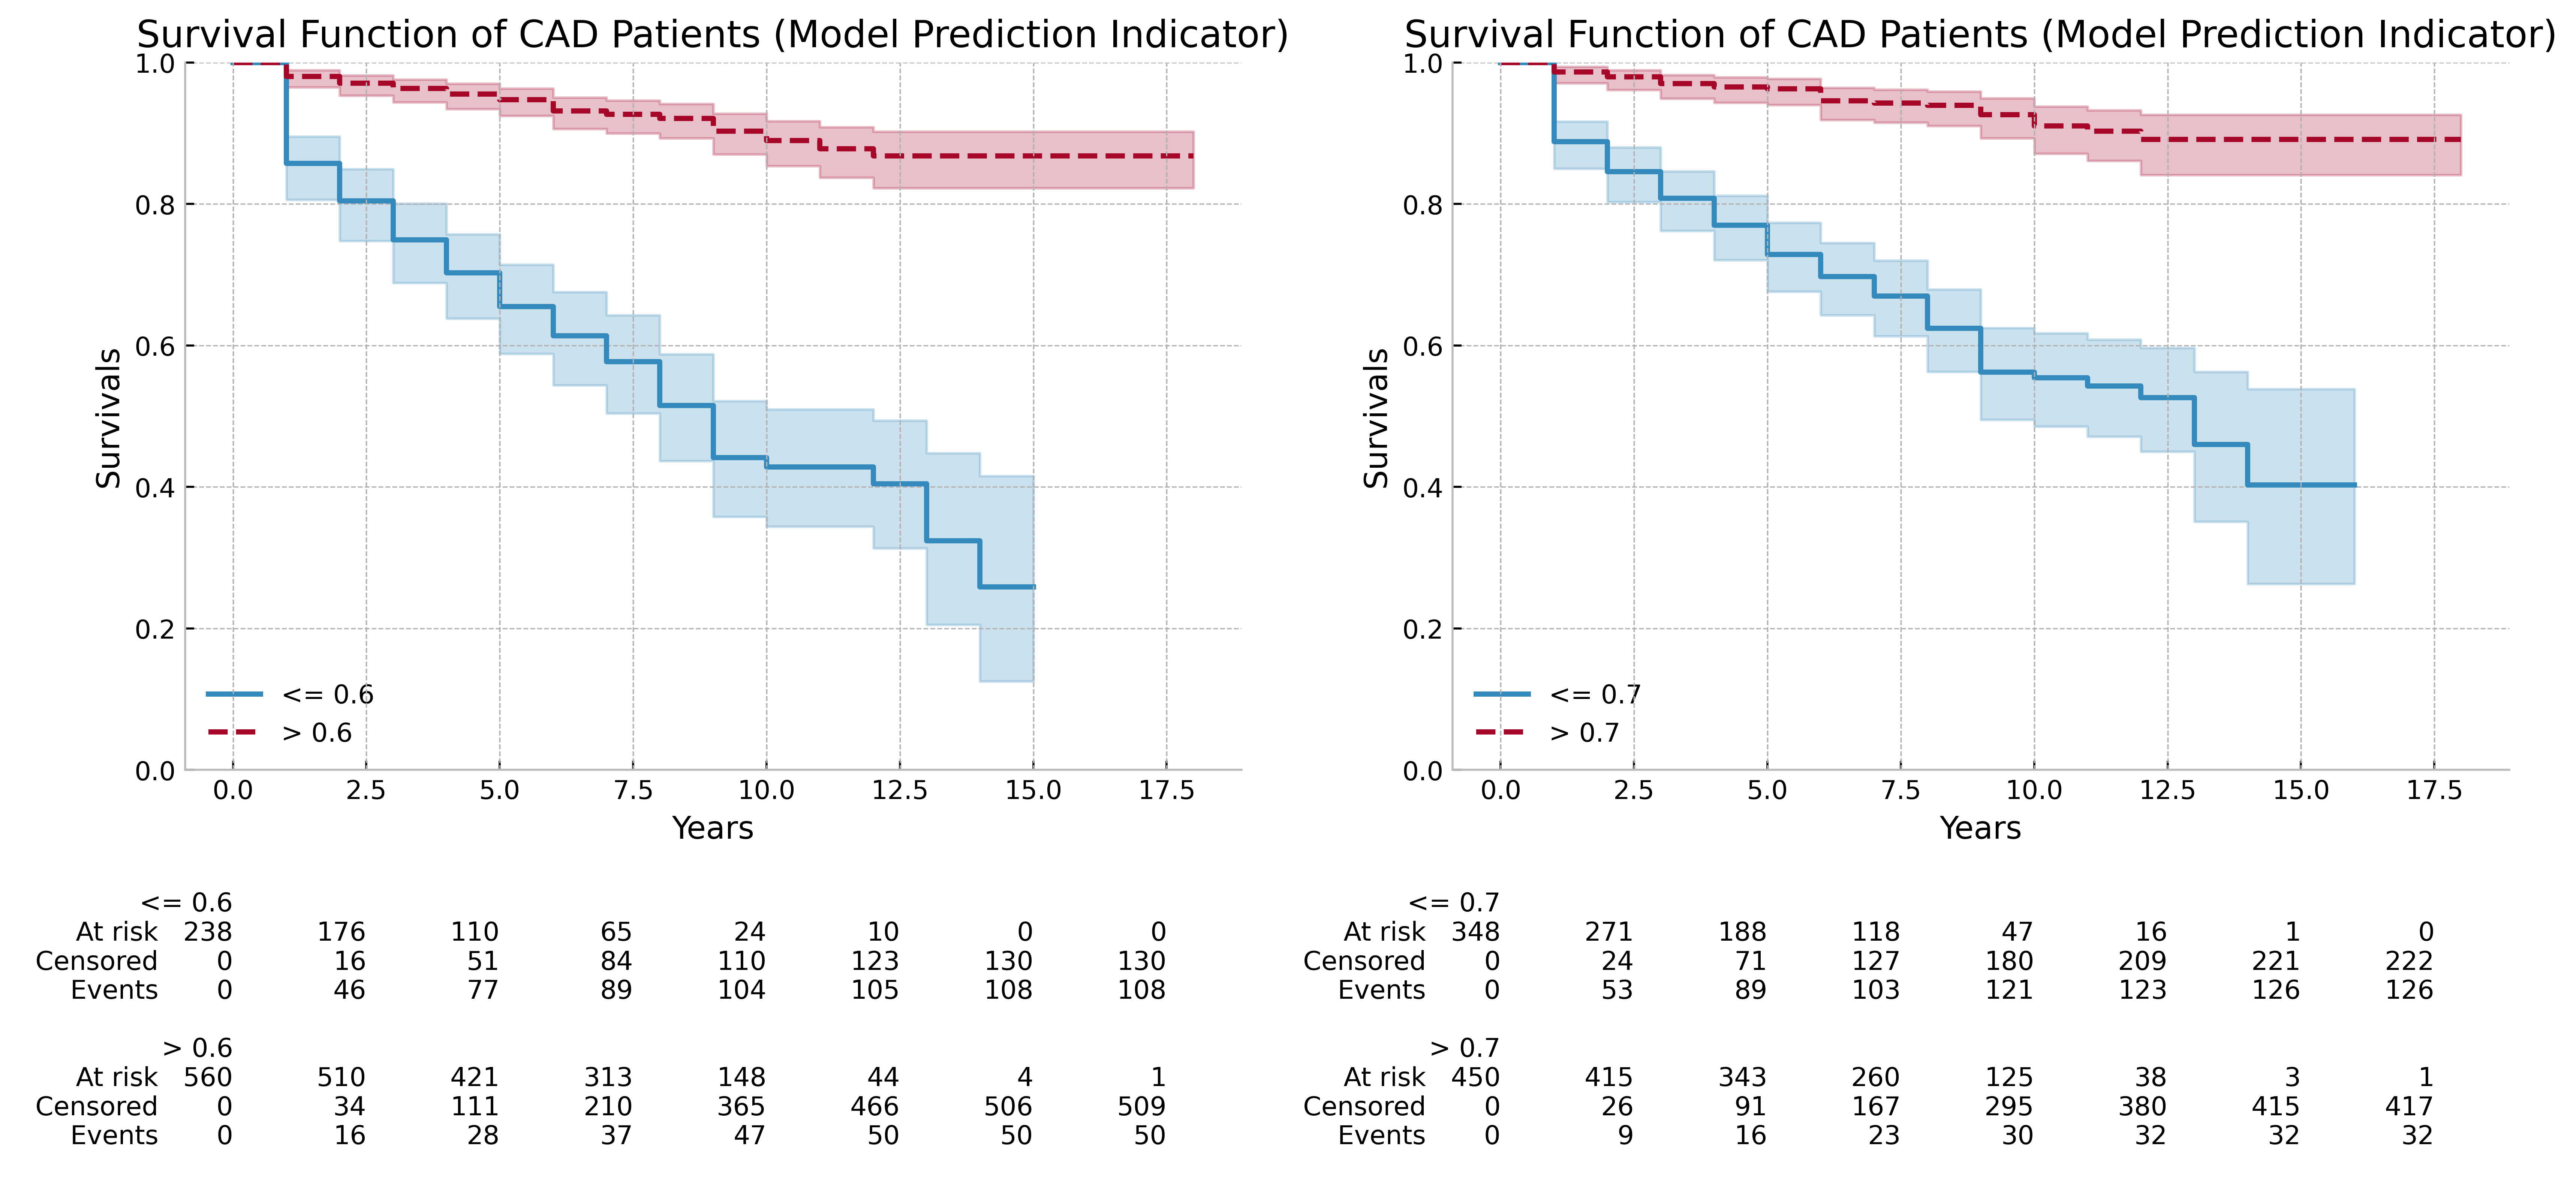

In [53]:
# Plots
fig = plt.figure(figsize=(16, 5), dpi=500) 
fig_dims = (1, 2)
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot2grid(fig_dims, (0, 0))
plot_kmf(df_test_pred, threshold=0.6)

plt.subplot2grid(fig_dims, (0, 1))
plot_kmf(df_test_pred, threshold=0.7)

# plt.subplot2grid(fig_dims, (1, 1))
# plot_kmf(df_test_pred, threshold=0.8)

### 3- COX Regression and p-value 

In [55]:
# Top variables
cph = CoxPHFitter()
cph.fit(df_test_pred.loc[:, ["Age", "FE", "Previous Myocardial Infarction", "Hyperlipemia\nHistoty of hyperlipemia", "duration", "observed"]], duration_col='duration', event_col='observed')
# cph.print_summary()

<lifelines.CoxPHFitter: fitted with 798 total observations, 640 right-censored observations>

In [60]:
# Model's output
cph = CoxPHFitter()
# cph.fit(df_test_pred.loc[:, ["ModelOutput", "duration", "observed"]], duration_col='duration', event_col='observed')
cph.fit(df_test4_pred.loc[:, ["ModelOutput", "duration", "observed"]], duration_col='duration', event_col='observed')
cph.print_summary()

/home/dot/miniconda3/envs/ipoteri/lib/python3.10/site-packages/lifelines/utils/printer.py:62: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return summary_df[columns].to_latex(float_format="%." + str(self.decimals) + "f")


<lifelines.CoxPHFitter: fitted with 798 total observations, 640 right-censored observations>
             duration col = 'duration'
                event col = 'observed'
      baseline estimation = breslow
   number of observations = 798
number of events observed = 158
   partial log-likelihood = -968.11
         time fit was run = 2022-06-28 14:02:05 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
ModelOutput  -1.37       0.25       0.18            -1.71            -1.02                 0.18                 0.36

              cmp to     z      p   -log2(p)
covariate                                   
ModelOutput     0.00 -7.71 <0.005      46.15
---
Concordance = 0.62
Partial AIC = 1938.22
log-likelihood ratio test = 51.63 on 1 df
-log2(p) of ll-ratio test = 40.44

In [54]:
# Top variables + Model27
cph = CoxPHFitter()
cph.fit(df_test_pred.loc[:, ["Age", "FE", "Previous Myocardial Infarction", "Hyperlipemia\nHistoty of hyperlipemia", "ModelOutput", "duration", "observed"]], duration_col='duration', event_col='observed')
# cph.print_summary()

<lifelines.CoxPHFitter: fitted with 798 total observations, 640 right-censored observations>

In [56]:
# Top variables + Model4
cph = CoxPHFitter()
cph.fit(df_test4_pred.loc[:, ["Age", "FE", "Previous Myocardial Infarction", "Hyperlipemia\nHistoty of hyperlipemia", "ModelOutput", "duration", "observed"]], duration_col='duration', event_col='observed')
cph.print_summary()

/home/dot/miniconda3/envs/ipoteri/lib/python3.10/site-packages/lifelines/utils/printer.py:62: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return summary_df[columns].to_latex(float_format="%." + str(self.decimals) + "f")


<lifelines.CoxPHFitter: fitted with 798 total observations, 640 right-censored observations>
             duration col = 'duration'
                event col = 'observed'
      baseline estimation = breslow
   number of observations = 798
number of events observed = 158
   partial log-likelihood = -893.15
         time fit was run = 2022-06-28 14:00:03 UTC

---
                                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                     
Age                                     0.05       1.05       0.01             0.03             0.07                 1.03                 1.07
FE                                     -0.06       0.94       0.01            -0.07            -0.05                 0.93                 0.96
Previous Myocardial Infarction          0.06       1.06       0.18            -0.29             0.41                 0.75                 1.51
Hyperlipemia\nHistoty of hyperlipemia  -0.61       0.55       0.18            -0.95            -0.26                 0.39                 0.77
ModelOutput                            -0.19       0.83       0.20            -0.59             0.21                 0.56                 1.24

                                        cmp to     z      p   -log2(p)
covariate                                                             
Age                                       0.00  5.87 <0.005      27.74
FE                                        0.00 -8.55 <0.005      56.22
Previous Myocardial Infarction            0.00  0.33   0.74       0.44
Hyperlipemia\nHistoty of hyperlipemia     0.00 -3.45 <0.005      10.80
ModelOutput                               0.00 -0.91   0.36       1.47
---
Concordance = 0.81
Partial AIC = 1796.29
log-likelihood ratio test = 201.56 on 5 df
-log2(p) of ll-ratio test = 135.80

In [72]:
250 / len(df["Vessels"])

0.06270378730875345